# Experiments results - final plotting notebooks.

This notebook contains all the code to create the plots and result table in the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pathlib import Path
from scipy.stats import wilcoxon

sns.set_style("whitegrid")
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.sans-serif"] = "Times"


def is_significant(ref, new, n_hypothesis):
    if (ref - new).sum() == 0:
        return ""
    p = wilcoxon(ref, new, nan_policy="omit", alternative="two-sided")[1] * n_hypothesis
    return f" ({p:.0E})" if p < 0.05 else f" ({p:.3f})"  # ({p2:.3f})"

In [2]:
number_of_models = {}
all_metrics_df = {}
all_datasets = [
    "imagenet",
    "pathmnist",
    "cifar10",
    "living17",
    "nonliving26",
    "entity13",
    "entity30",
    "wilds_fmow",
    "wilds_rr1",
    "wilds_camelyon",
    "wilds_icam",
    "pacs",
    "mnist",
    "imageneta",
]
for dataset in all_datasets:
    print(dataset)
    dataset_dir = Path(f"/data/performance_estimation/outputs/{dataset}")
    all_submodels = [f for f in dataset_dir.iterdir() if f.is_dir()]
    all_metrics = pd.DataFrame()
    nb_model = 0
    for model in all_submodels:
        for run in model.iterdir():
            if run.is_dir():
                if (model / run / "metrics.csv").exists():
                    df = pd.read_csv(model / run / "metrics.csv")
                    if "error_atc_ts_csdist" in df.columns:
                        df.dropna(subset="error_atc_ts_csdist", inplace=True)
                    else:
                        continue
                    df["model"] = f"{model.stem}_{run.stem}"
                    all_metrics = pd.concat([all_metrics, df], ignore_index=True)
                    if "error_atc_ts_csdist" in df.columns:
                        nb_model += df.seed.unique().size
    all_metrics["ood_dataset"] = all_metrics["dataset"]
    if not dataset in ["imagenet"]:
        all_metrics["dataset"] = dataset
        all_metrics_df[dataset] = all_metrics
        number_of_models[dataset] = nb_model
    else:
        if dataset == "imagenet":
            all_metrics_df["imagenet_sketch"] = all_metrics.loc[all_metrics.dataset == "imagenet_sketch"]
            number_of_models["imagenet_sketch"] = len(all_metrics_df["imagenet_sketch"])
            all_metrics_df["imagenetV2"] = all_metrics.loc[all_metrics.dataset == "imagenet_v2_a"]
            number_of_models["imagenetV2"] = len(all_metrics_df["imagenetV2"])
aggregated = pd.concat(all_metrics_df.values())

imagenet
pathmnist
cifar10
living17
nonliving26
entity13
entity30
wilds_fmow
wilds_rr1
wilds_camelyon
wilds_icam
pacs
mnist
imageneta


In [3]:
all_datasets.extend(["imagenet_sketch", "imagenetV2"])
all_datasets.pop(0);

## Main ATC-DistCS experiments

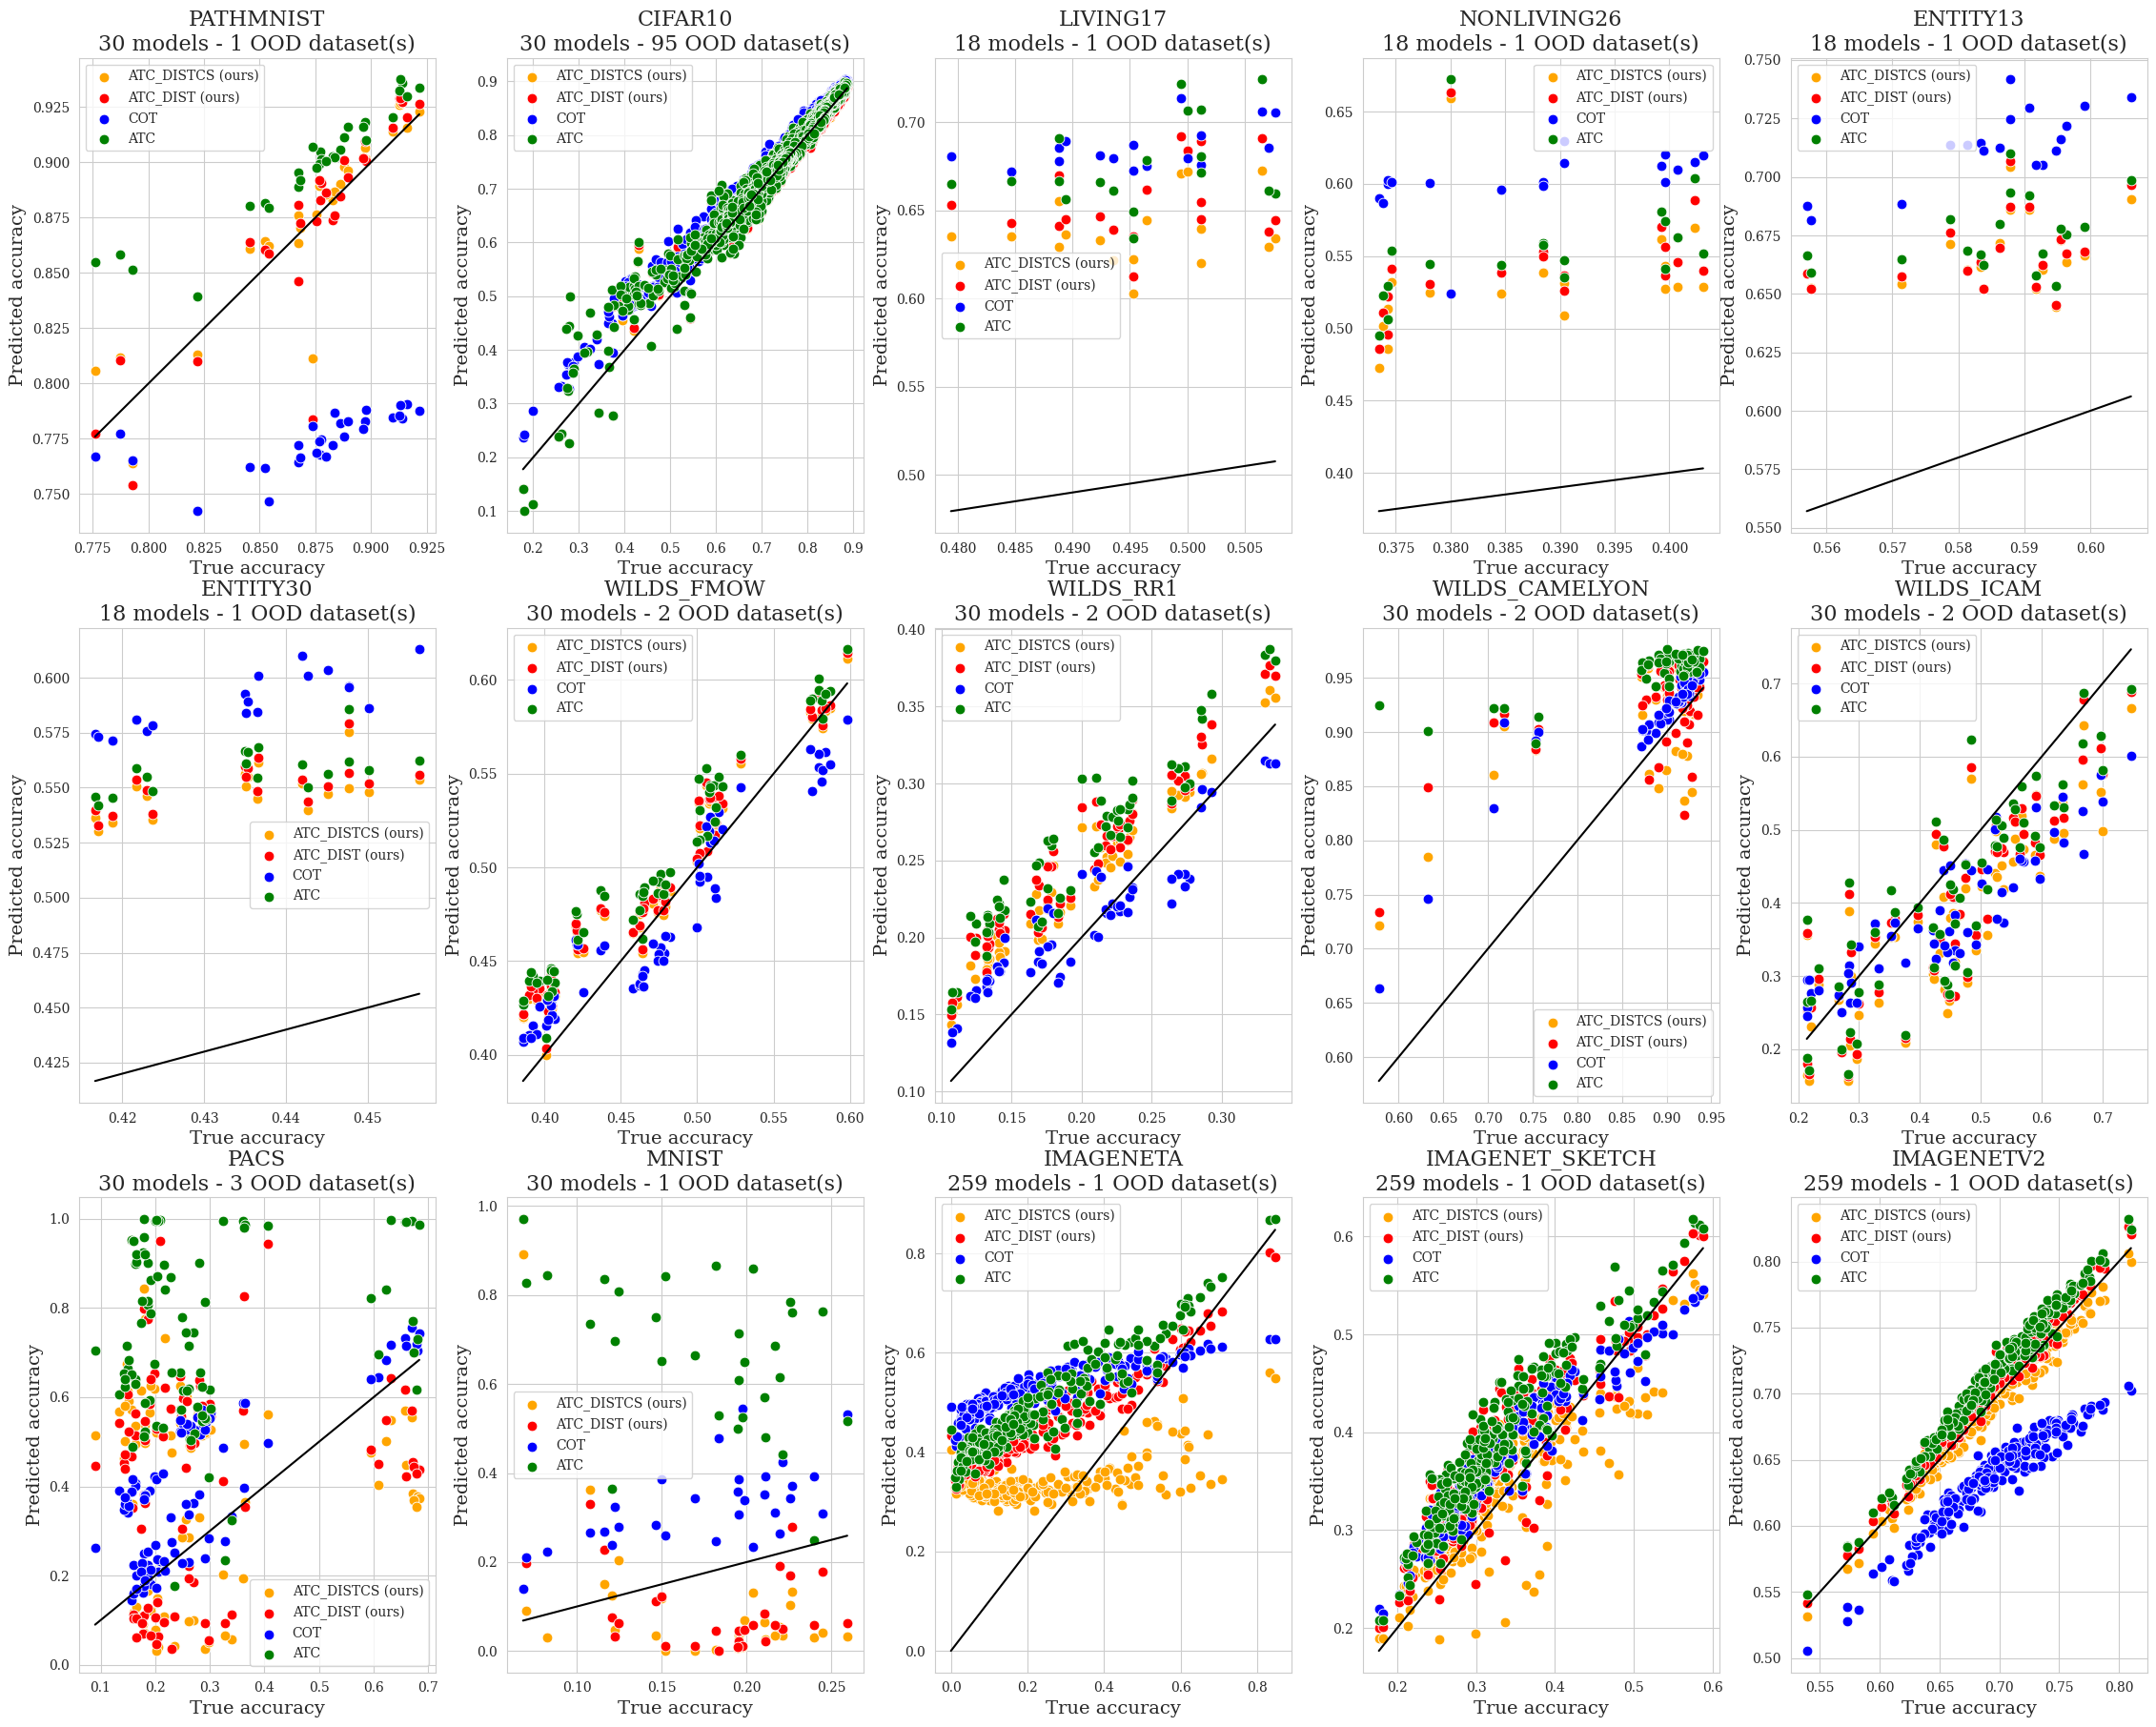

In [4]:
f, ax = plt.subplots(3, 5, figsize=(28, 22))
ax = ax.ravel()
for i, dataset in enumerate(all_datasets):
    try:
        sns.scatterplot(
            data=all_metrics_df[dataset],
            x="accuracy",
            y="predicted_atc_ts_csdist",
            label="ATC_DISTCS (ours)",
            ax=ax[i],
            s=60,
            color="orange",
        )
        sns.scatterplot(
            data=all_metrics_df[dataset],
            x="accuracy",
            y="predicted_atc_ts_dist",
            label="ATC_DIST (ours)",
            ax=ax[i],
            s=60,
            color="red",
        )
        sns.scatterplot(
            data=all_metrics_df[dataset], x="accuracy", y="predicted_cot_ts", label="COT", ax=ax[i], s=60, color="blue"
        )

        sns.scatterplot(
            data=all_metrics_df[dataset],
            x="accuracy",
            y="predicted_atc_ts",
            label="ATC",
            ax=ax[i],
            s=60,
            color="green",
        )
        sns.lineplot(data=all_metrics_df[dataset], x="accuracy", y="accuracy", color="black", ax=ax[i])
        ax[i].set_ylabel("Predicted accuracy", fontsize=14)
        ax[i].set_xlabel("True accuracy", fontsize=14)
        ax[i].set_title(
            dataset.upper()
            + f"\n{number_of_models[dataset]} models - {all_metrics_df[dataset].ood_dataset.unique().size} OOD dataset(s)",
            fontsize=16,
        )
    except:
        continue
plt.show()
f.savefig("scatterplots_all.pdf", bbox_inches="tight")

<AxesSubplot: xlabel='accuracy', ylabel='error_cot_ts'>

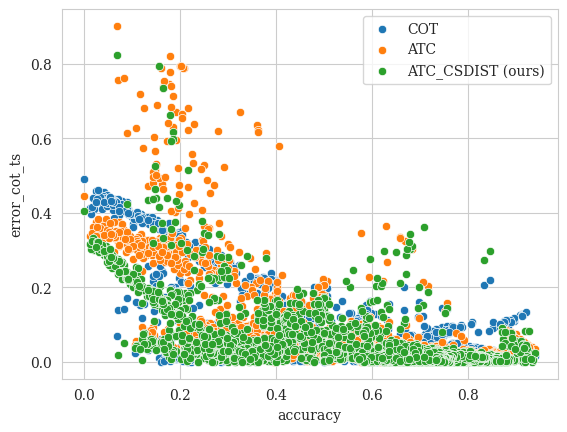

In [28]:
sns.scatterplot(data=aggregated, x="accuracy", y="error_cot_ts", label="COT")
sns.scatterplot(data=aggregated, x="accuracy", y="error_atc_ts", label="ATC")
sns.scatterplot(data=aggregated, x="accuracy", y="error_atc_ts_csdist", label="ATC_CSDIST (ours)")

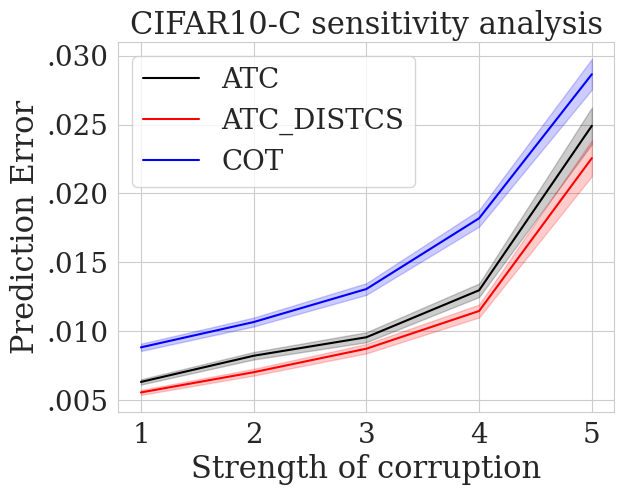

In [5]:
all_metrics_df["cifar10"]["strength"] = all_metrics_df["cifar10"]["ood_dataset"].apply(lambda x: int(x[-1])) + 1
sns.lineplot(
    data=all_metrics_df["cifar10"], y="error_atc_cs_ts", x="strength", color="black", label="ATC", errorbar="se"
)
sns.lineplot(
    data=all_metrics_df["cifar10"],
    y="error_atc_cs_ts_csdist",
    x="strength",
    color="red",
    label="ATC_DISTCS",
    errorbar="se",
)
sns.lineplot(
    data=all_metrics_df["cifar10"], y="error_cot_cs_ts", x="strength", color="blue", label="COT", errorbar="se"
)
plt.ylabel("Prediction Error", fontsize=22)
plt.xlabel("Strength of corruption", fontsize=22)
plt.title("CIFAR10-C sensitivity analysis", fontsize=22)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.3f}".lstrip("0"))
ax.set_xticks([1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5], rotation=0)
ax.tick_params(axis="both", which="major", labelsize=20)
plt.legend(prop={"size": 20})
plt.savefig("corruption_analysis.pdf", bbox_inches="tight")

In [ ]:
error_cols_ts = [
    "error_doc_ts",
    "error_cot_ts",
    "error_atc_ts",
    "error_atc_ts_dist",
    "error_atc_ts_csdist",
]
error_cols_ts_cs = ["error_atc_cs_ts", "error_cot_cs_ts", "error_atc_cs_ts_dist", "error_atc_cs_ts_csdist"]  #
all_error_cols = error_cols_ts + error_cols_ts_cs

for dataset in all_datasets:
    try:
        df_all = all_metrics_df[dataset]
        means = df_all[all_error_cols].aggregate(np.mean)
        best_baseline = means.index[means.argmin()]
        results = df_all[all_error_cols].aggregate(
            func=lambda x: f"{np.nanmean(x * 100, keepdims=True)[0]:.2f}"
            + is_significant(df_all[best_baseline].values, x, n_hypothesis=len(all_error_cols) - 1)
        )
        print(f"{dataset.upper()}")
        display(results)
    except:
        pass

In [12]:
error_cols_ts = [
    "error_cot_ts",
    "error_atc_ts",
    # "error_atc_ts_dist",
    "error_atc_ts_csdist",
]
error_cols_ts_cs = ["error_atc_cs_ts", "error_cot_cs_ts", "error_atc_cs_ts_dist", "error_atc_cs_ts_csdist"]  #
all_error_cols = error_cols_ts + error_cols_ts_cs
from sklearn.feature_selection import r_regression
from scipy.stats import pearsonr
for dataset in all_datasets:
    try:
        print(dataset)
        df_all = all_metrics_df[dataset]
        print(r_regression(df_all[error_cols_ts], df_all["accuracy"]))
    except:
        pass

pathmnist
[ 0.95456726 -0.85430895 -0.42897879]
cifar10
[-0.54318734 -0.59273734 -0.62155835]
living17
[-0.18769899  0.01569561 -0.12963162]
nonliving26
[-0.02268764  0.06515547 -0.01133792]
entity13
[-0.0459078  -0.45453167 -0.45206583]
entity30
[-0.21744415 -0.599452   -0.56001209]
wilds_fmow
[-0.04379332 -0.60407266 -0.57844551]
wilds_rr1
[-0.44649241 -0.49550173 -0.70279614]
wilds_camelyon
[-0.81881916 -0.98481285 -0.85620519]
wilds_icam
[ 0.65807402 -0.03145033  0.33611673]
pacs
[-0.21551717 -0.56987147 -0.2434357 ]
mnist
[ 0.07405812 -0.67427621 -0.07206191]
imageneta
[-0.95315969 -0.94887387 -0.46476538]
imagenet_sketch
[-0.39471202 -0.28440322  0.24740901]
imagenetV2
[0.80031039 0.05763513 0.24254061]


In [ ]:
mae_per_dataset = aggregated.groupby("dataset")[
    [
        "error_atc_ts",
        "error_atc_ts_csdist",
        "error_cot_ts",
        "error_atc_cs_ts_csdist",
        "error_cot_cs_ts",
    ]
].mean()
print(
    f'Median_relative_mae_improvement_atc_ts {np.percentile(((mae_per_dataset["error_atc_ts"] - mae_per_dataset["error_atc_ts_csdist"]) / mae_per_dataset["error_atc_ts"]).values, 50)}'
)
print(
    f'Median_relative_mae_improvement_cot {np.percentile(((mae_per_dataset["error_cot_ts"] - mae_per_dataset["error_atc_ts_csdist"]) / mae_per_dataset["error_cot_ts"]).values, 50)}'
)
print(
    f'Median_relative_mae_improvement_cot_cs {np.percentile(((mae_per_dataset["error_cot_cs_ts"] - mae_per_dataset["error_atc_cs_ts_csdist"]) / mae_per_dataset["error_cot_cs_ts"]).values, 50)}'
)

## Mahalanabis versus KNN ablation study

In [ ]:
# f, ax = plt.subplots(1, 5, figsize=(25, 5))

ds_to_plot = [ds for ds in all_datasets if not ds.startswith("imagenet")]
ds_to_plot_split = [ds_to_plot[:6], ds_to_plot[6:]]
for p, ds_list in enumerate(ds_to_plot_split):
    f, ax = plt.subplots(1, 6, figsize=(25, 5))
    ax = ax.ravel()
    for i, dataset in enumerate(ds_list):
        print(dataset)
        error_cols_nice = [
            "error_atc_ts",
            "error_atc_ts_csdist",
            "error_atc_ts_maha_dist",
        ]
        xs = [0, 1, 2]
        labels = ["ATC", "+DistCS", "+Maha"]
        try:
            sns.boxplot(
                y=np.concatenate([all_metrics_df[dataset][c].dropna().values for c in error_cols_nice]),
                x=np.concatenate(
                    [
                        np.repeat(x, all_metrics_df[dataset][c].dropna().values.size)
                        for x, c in zip(xs, error_cols_nice)
                    ]
                ),
                palette=["#004C99"],
                ax=ax[i],
                showfliers=False,
                whis=[5, 95],
            )
            ax[i].set_xticks(xs, labels=labels, rotation=15)
            ax[i].tick_params(axis="both", which="major", labelsize=20)
            ax[i].yaxis.set_major_formatter(lambda x, pos: f"{x:00.2f}".lstrip("0"))
            ax[i].set_title(
                dataset.upper(),
                # + f"\n{number_of_models[dataset]} models", # - {all_metrics_df[dataset].dataset.unique().size} OOD dataset(s)
                fontsize=20,
            )
        except KeyError:
            continue
    plt.show()
    f.savefig(f"maha_ablation_results_{p}.pdf", bbox_inches="tight")

## Number of neighbors ablation

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, dataset in enumerate(["living17", "pathmnist", "nonliving26", "wilds_icam", "wilds_camelyon"]):
    df = pd.read_csv(f"/data/performance_estimation/outputs/{dataset}/ablation_all.csv")

    sns.boxplot(
        data=df,
        x="n_neighbors",
        y="error_atc_ts_dist",
        ax=ax[i],
        hue="normalise",
        palette={True: "#7EA6E0", False: "#004C99"},
        whis=[5, 95],
        showfliers=False,
    )

    ax[i].legend(loc="upper right", title="Normalised\nfeatures")
    ax[i].set_title(dataset.upper())
    if i == 0:
        ax[i].set_ylabel("Error for ATC-Dist")
    else:
        ax[i].set_ylabel("")
    ax[i].set_xlabel("Number of neighbours")
plt.show()
f.savefig("ablation_global.pdf", bbox_inches="tight")

In [ ]:
f, ax = plt.subplots(1, 6, figsize=(22, 4))
for i, dataset in enumerate(["pathmnist", "pacs", "mnist", "wilds_icam", "living17", "wilds_camelyon"]):
    df = pd.read_csv(f"/data/performance_estimation/outputs/{dataset}/ablation_q_all.csv")

    sns.boxplot(
        data=df, x="quantile", y="error_atc_cs_ts_csdist", ax=ax[i], whis=[5, 95], showfliers=False, color="#004C99"
    )

    ax[i].set_title(dataset.upper(), fontsize=20)
    if i == 0:
        ax[i].set_ylabel("Error for ATC-DistCS", fontsize=18)
    else:
        ax[i].set_ylabel("")
    ax[i].set_xlabel("Val Dist Quantile", fontsize=18)
    ax[i].tick_params(axis="both", which="major", labelsize=18)
    ax[i].yaxis.set_major_formatter(lambda x, pos: f"{x:00.2f}".lstrip("0"))
plt.show()
f.savefig("ablation_q.pdf", bbox_inches="tight")